## Importing Libraries

In [1665]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, jaccard_score
import plotly.express as px
import numpy as np
from collections import Counter
from matplotlib import pyplot as plt
import seaborn as sns
from graphviz import Digraph

## Loading the Data

In [1666]:
df = pd.read_csv("Breast_Cancer.csv", header=0, delimiter=',')
df.head()

,Age,Race,Marital Status,T Stage,N Stage,6th Stage,differentiate,Grade,A Stage,Tumor Size,Estrogen Status,Progesterone Status,Regional Node Examined,Reginol Node Positive,Survival Months,Status
0,68,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,4,Positive,Positive,24,1,60,Alive
1,50,White,Married,T2,N2,IIIA,Moderately differentiated,2,Regional,35,Positive,Positive,14,5,62,Alive
2,58,White,Divorced,T3,N3,IIIC,Moderately differentiated,2,Regional,63,Positive,Positive,14,7,75,Alive
3,58,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,18,Positive,Positive,2,1,84,Alive
4,47,White,Married,T2,N1,IIB,Poorly differentiated,3,Regional,41,Positive,Positive,3,1,50,Alive


## Dataset Inspection

In [1667]:
numerical_cols = ['Age','Tumor Size','Regional Node Examined','Reginol Node Positive','Survival Months']
categorical_cols = ['Race','Marital Status','T Stage ','N Stage','6th Stage','differentiate','Grade','A Stage','Estrogen Status','Progesterone Status']

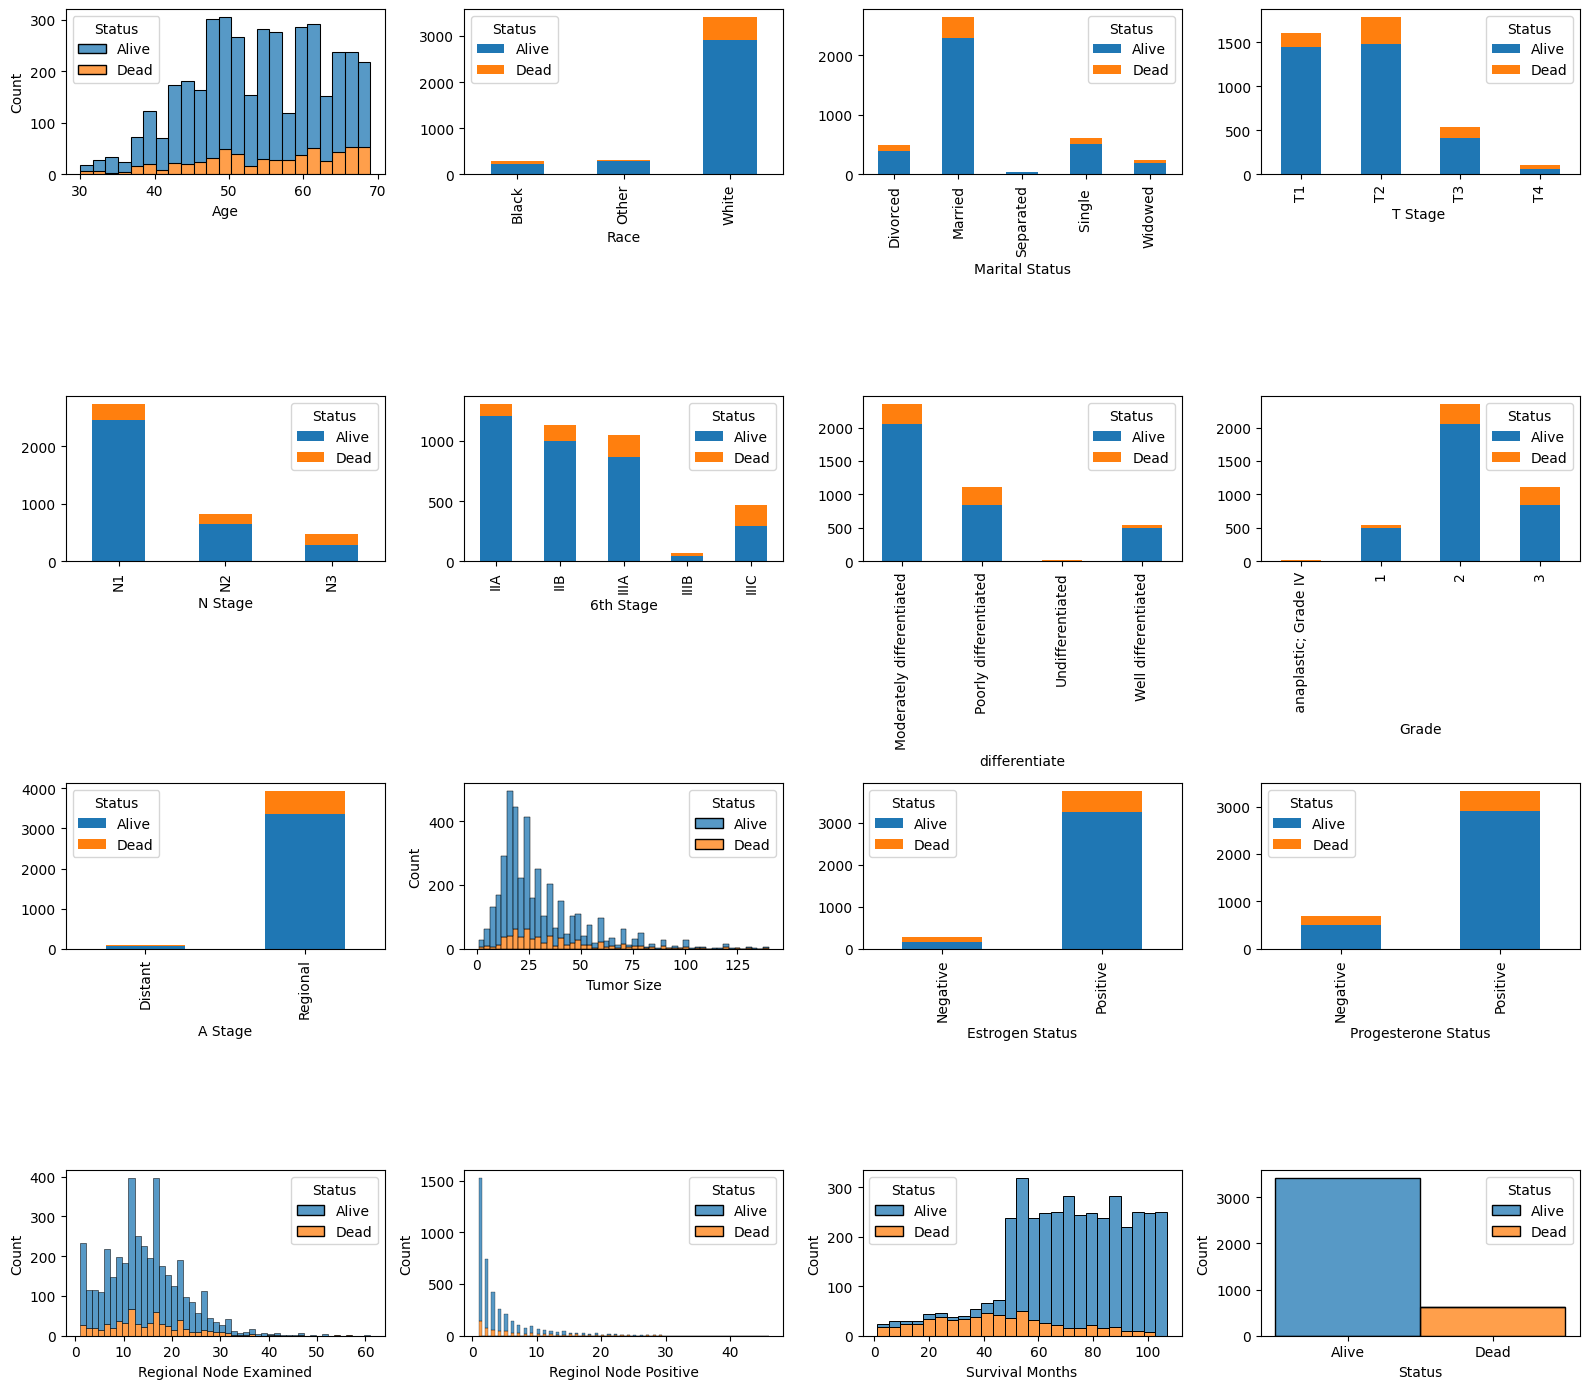

In [1668]:
fig, axes = plt.subplots(4,4,figsize=(16,14))

for i, c in enumerate(df.columns):
    ax = axes.reshape(-1)[i]
    if c in categorical_cols:
        ct = pd.crosstab(index=df[c], columns=df['Status'])
        a = ct.plot(kind='bar', stacked=True,ax=ax)
    else: 
        sns.histplot(x=c,data=df, hue='Status',ax=ax, multiple='stack')
plt.tight_layout()

<Axes: >

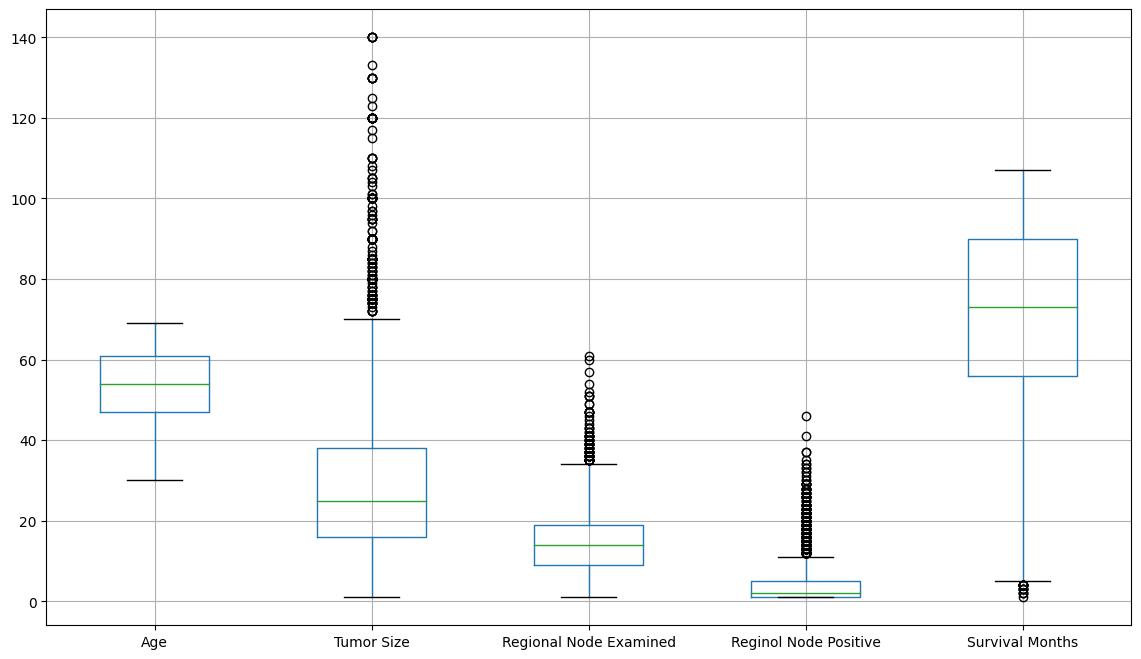

In [1669]:
df.loc[:,numerical_cols].boxplot(figsize=(14,8))

## Transformations

<Axes: ylabel='Frequency'>

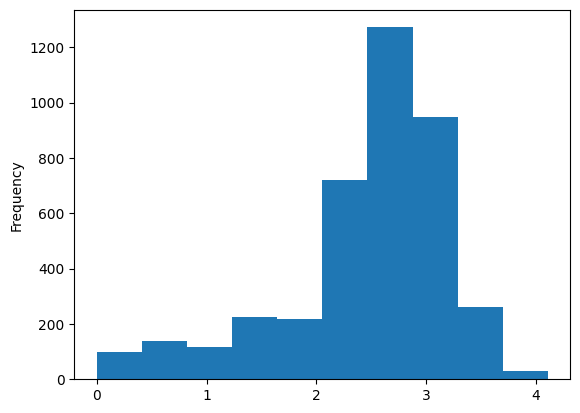

In [1670]:
df['Regional Node Examined'] = df['Regional Node Examined'].apply('log')
df['Regional Node Examined'].plot.hist()


<Axes: ylabel='Frequency'>

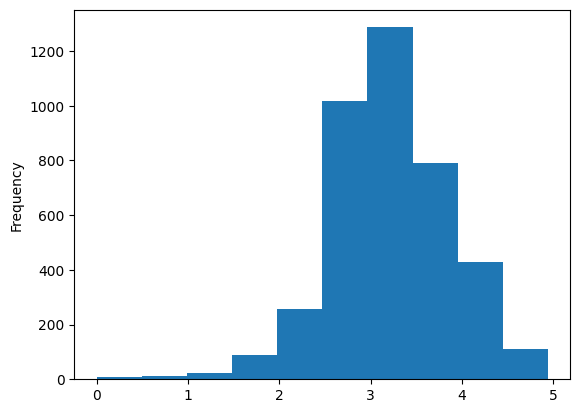

In [1671]:
df['Tumor Size'] = df['Tumor Size'].apply('log')
df['Tumor Size'].plot.hist()

## Train Test Split

In [1672]:
X = df.loc[:,df.columns != 'Status']
y = df['Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)


## Outlier Detection

<Axes: ylabel='Frequency'>

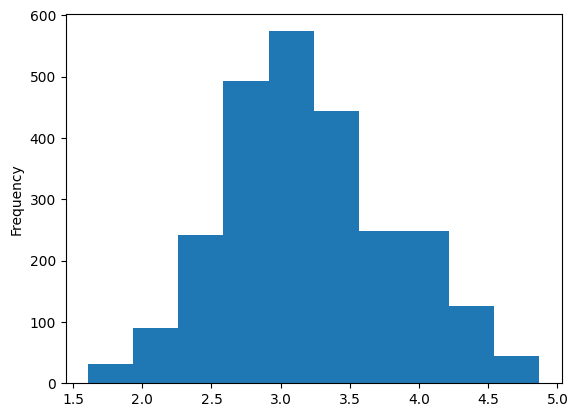

In [1673]:
# Calculate the IQR range
Q1 = X_train['Tumor Size'].quantile(0.25)
Q3 = X_train['Tumor Size'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Detect outliers for 'Tumor Size'
outliers_tumor_size = (X_train['Tumor Size'] < lower_bound) | (X_train['Tumor Size'] > upper_bound)

# Remove outliers from 'Tumor Size'
X_train = X_train[~outliers_tumor_size]
y_train = y_train[~outliers_tumor_size]

X_train['Tumor Size'].plot.hist()

<Axes: ylabel='Frequency'>

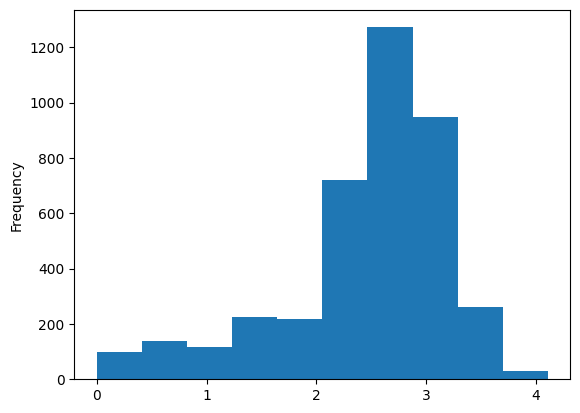

In [1674]:
# Calculate the IQR range
Q1 = X_train['Regional Node Examined'].quantile(0.25)
Q3 = X_train['Regional Node Examined'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Detect outliers for 'Regional Node Examined'
outliers_regional_node = (X_train['Regional Node Examined'] < lower_bound) | (X_train['Regional Node Examined'] > upper_bound)

# Remove outliers from 'Regional Node Examined'
X_train = X_train[~outliers_regional_node]
y_train = y_train[~outliers_regional_node]

df['Regional Node Examined'].plot.hist()

## Preprocessing

In [1675]:
def preprocessing(X, y, scaler=None):
    # We scale all the columns
    if scaler is None: 
        # We only want the scaler to fit the train data
        scaler = MinMaxScaler()
        X[numerical_cols] = scaler.fit_transform(X[numerical_cols])
    else: 
        X[numerical_cols] = scaler.transform(X[numerical_cols])
    # One Hot Encoding
    X = pd.get_dummies(X, columns = categorical_cols)
    # Encode output
    status_map = {'Dead': 1, 'Alive': 0}
    y = y.map(status_map)
    y = y.rename('Dead')
    return X, y, scaler

X_train, y_train, scaler = preprocessing(X_train,y_train)
X_val, y_val, _ = preprocessing(X_val, y_val, scaler)
X_test, y_test, _ = preprocessing(X_test,y_test,scaler)
X_train.head()

,Age,Tumor Size,Regional Node Examined,Reginol Node Positive,Survival Months,Race_Black,Race_Other,Race_White,Marital Status_Divorced,Marital Status_Married,...,Grade_ anaplastic; Grade IV,Grade_1,Grade_2,Grade_3,A Stage_Distant,A Stage_Regional,Estrogen Status_Negative,Estrogen Status_Positive,Progesterone Status_Negative,Progesterone Status_Positive
844,0.794872,0.393154,0.479625,0.000000,0.924528,0,1,0,1,0,...,0,0,1,0,0,1,0,1,0,1
1993,0.256410,0.375611,0.293145,0.000000,0.471698,0,0,1,0,1,...,0,0,1,0,0,1,0,1,0,1
270,0.102564,0.762687,0.507318,0.177778,0.367925,0,0,1,0,1,...,0,0,1,0,1,0,0,1,0,1
1359,0.076923,0.268706,0.507318,0.022222,0.698113,0,0,1,0,1,...,0,1,0,0,0,1,0,1,0,1
2157,0.410256,0.831176,0.449521,0.022222,0.481132,0,0,1,0,1,...,0,0,1,0,0,1,0,1,0,1


## Data Balancing

In [1676]:
print('Original dataset shape:', Counter(y_train))

Original dataset shape: Counter({0: 2006, 1: 368})


In [1677]:
from imblearn.combine import SMOTEENN

# Apply SMOTEENN for combined oversampling and undersampling
smote_enn = SMOTEENN(sampling_strategy='minority')
X_train, y_train = smote_enn.fit_resample(X_train, y_train)

print('Resampled dataset shape:', Counter(y_train))


Resampled dataset shape: Counter({1: 1626, 0: 1312})


## Support Functions

In [1678]:
results_df = pd.DataFrame(index=[], columns= ['**Recall class 1**', '**F1 class 1**','Accuracy', 'F1 Macro', 'Precision Macro', 'Recall Macro'])

In [1679]:
def compute_metrics(y_real,y_pred):
    recall_class_1 =recall_score(y_real,y_pred, pos_label=1)
    f1_class_1 =f1_score(y_real,y_pred, pos_label=1)
    accuracy = accuracy_score(y_real,y_pred)
    f1_macro =f1_score(y_real,y_pred, average='macro')
    precison_macro =precision_score(y_real,y_pred,  average='macro')
    recall_macro =recall_score(y_real,y_pred,  average='macro')
    return [recall_class_1, f1_class_1, accuracy,f1_macro,precison_macro,recall_macro ]

def confusion(true, pred):
    """
    Function for pretty printing confusion matrices
    """
    pred = pd.Series(pred)
    true = pd.Series(true)
    
    true.name = 'target'
    pred.name = 'predicted'
    cm = pd.crosstab(true.reset_index(drop=True), pred.reset_index(drop=True))
    cm = cm[cm.index]
    return cm

## LDA

In [1680]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda_model = LinearDiscriminantAnalysis()
lda_model.fit(X_train, y_train)
y_pred_lda = lda_model.predict(X_val)
results_df.loc['LDA',:] = compute_metrics(y_val, y_pred_lda)
results_df

,**Recall class 1**,**F1 class 1**,Accuracy,F1 Macro,Precision Macro,Recall Macro
LDA,0.69697,0.570248,0.838509,0.735411,0.711319,0.780595


In [1681]:
# Confusion matrix
confusion(y_val, y_pred_lda)

predicted,0,1
target,,
0,471,74
1,30,69


In [1682]:
# Exploring LDA
X_transformed = lda_model.transform(X_train)

X_transformed = pd.DataFrame(X_transformed)
X_transformed['labels'] = y_train.reset_index(drop=True)
X_transformed

,0,labels
0,-1.830650,0
1,-0.705094,0
2,-2.670494,0
3,-0.939160,0
4,-1.756839,0
...,...,...
2933,1.165138,1
2934,1.922890,1
2935,0.758221,1
2936,1.749817,1


<Axes: xlabel='0'>

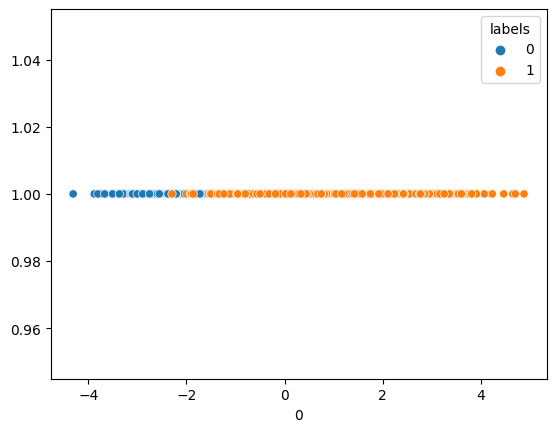

In [1683]:
sns.scatterplot(x= 0, y= 1, data = X_transformed, hue='labels')

## KNN

In [1684]:
from sklearn.neighbors import KNeighborsClassifier


index= pd.MultiIndex.from_arrays([[], []], names=('model', 'k'))
results_knn = pd.DataFrame(index=index, columns= ['**Recall class 1**', '**F1 class 1**','Accuracy', 'F1 Macro', 'Precision Macro', 'Recall Macro'])

k_values = range(1,50,2)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, metric='minkowski')
    knn = knn.fit(X_train,y_train)
    y_pred = knn.predict(X_val)
    results_knn.loc[('KNN',k), :] = compute_metrics(y_val, y_pred)

sorted_results_knn = results_knn.sort_values(by='**Recall class 1**', ascending=False)
print(sorted_results_knn)

         **Recall class 1** **F1 class 1**  Accuracy  F1 Macro  \
model k                                                          
KNN   15            0.79798       0.417989  0.658385  0.588116   
      23            0.79798       0.432877  0.678571  0.604304   
      21           0.787879       0.432133  0.681677  0.605495   
      19           0.787879       0.432133  0.681677  0.605495   
      17           0.787879        0.42623  0.673913  0.599232   
      13           0.777778       0.418478  0.667702  0.592935   
      11           0.767677       0.411924  0.663043  0.587899   
      25           0.757576       0.415512   0.67236  0.593948   
      9            0.747475        0.40327  0.659938  0.582742   
      5            0.747475       0.414566  0.675466  0.595038   
      27           0.747475       0.412256   0.67236  0.592565   
      7            0.737374       0.404432  0.666149  0.586251   
      29           0.737374       0.412429  0.677019  0.594866   
      33  

In [1685]:

# Retrieve the k value of the first row
first_row = sorted_results_knn.iloc[0]
k_value = first_row.name[1]

print("k value of the first row:", k_value)

knn = KNeighborsClassifier(n_neighbors=k_value)
knn = knn.fit(X_train,y_train)
y_pred_knn = knn.predict(X_val)
results_df.loc['KNN-'+str(k_value), :] = compute_metrics(y_val, y_pred_knn)
results_df.sort_values(by='**Recall class 1**', ascending=False)

k value of the first row: 15


,**Recall class 1**,**F1 class 1**,Accuracy,F1 Macro,Precision Macro,Recall Macro
KNN-15,0.79798,0.417989,0.658385,0.588116,0.61418,0.715504
LDA,0.69697,0.570248,0.838509,0.735411,0.711319,0.780595


In [1686]:
# Confusion matrix
confusion(y_val, y_pred_knn)

predicted,0,1
target,,
0,345,200
1,20,79


## Logistic Regression

In [1687]:
from sklearn.linear_model import LogisticRegression


index= pd.MultiIndex.from_arrays([[], []], names=('model', 'C'))
results_logreg = pd.DataFrame(index=index, columns= ['**Recall class 1**', '**F1 class 1**','Accuracy', 'F1 Macro', 'Precision Macro', 'Recall Macro'])

lambdas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]

for l in lambdas:
    C = 1/l
    logreg = LogisticRegression(C=C, max_iter=1000, random_state=42)
    logreg = logreg.fit(X_train,y_train)
    y_pred = logreg.predict(X_val)
    results_logreg.loc[('LogReg', C), :] = compute_metrics(y_val, y_pred)

sorted_results_logreg = results_logreg.sort_values(by='**Recall class 1**', ascending=False)
sorted_results_logreg

**Recall class 1** **F1 class 1**  Accuracy  F1 Macro  \
model  C                                                                
LogReg 0.1                0.777778       0.501629  0.762422  0.672833   
       1.0                0.717172       0.527881  0.802795  0.701625   
       10.0               0.686869        0.53125  0.813665  0.707485   
       100000.0           0.666667       0.525896  0.815217  0.705571   
       10000.0            0.666667        0.52381  0.813665   0.70399   
       1000.0             0.666667        0.52381  0.813665   0.70399   
       100.0              0.666667       0.521739  0.812112  0.702415   

                Precision Macro Recall Macro  
model  C                                      
LogReg 0.1             0.659867     0.768705  
       1.0             0.679288      0.76776  
       10.0            0.684733     0.761783  
       100000.0        0.683569     0.754434  
       10000.0         0.682081     0.753517  
       1000.0          0.682081     0.753517  
       100.0           0.680612     0.752599

In [1688]:
# Retrieve the k value of the first row
first_row = sorted_results_logreg.iloc[0]
c_value = first_row.name[1]

print("c value of the first row:", c_value)

logreg = LogisticRegression(C=c_value, max_iter=1000).fit(X_train,y_train)
y_pred_logreg = logreg.predict(X_val)
results_df.loc['LogReg-'+str(c_value), :] = compute_metrics(y_val, y_pred_logreg)

results_df.sort_values(by='**Recall class 1**', ascending=False)

c value of the first row: 0.1


,**Recall class 1**,**F1 class 1**,Accuracy,F1 Macro,Precision Macro,Recall Macro
KNN-15,0.79798,0.417989,0.658385,0.588116,0.61418,0.715504
LogReg-0.1,0.777778,0.501629,0.762422,0.672833,0.659867,0.768705
LDA,0.69697,0.570248,0.838509,0.735411,0.711319,0.780595


In [1689]:
# Confusion matrix
confusion(y_val, y_pred_logreg)

predicted,0,1
target,,
0,414,131
1,22,77


## Random Forest

In [1690]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 300, 500],  # Number of trees in the forest
    'max_depth': [None, 5, 10],       # Maximum depth of each tree
    'min_samples_split': [2, 5, 10]   # Minimum number of samples required to split an internal node
}

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=rf_classifier, 
                           param_grid=param_grid, 
                           scoring=['recall', 'f1','accuracy', 'f1_macro', 'precision_macro', 'recall_macro'],
                           cv=5,
                           refit='recall')

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Print the best parameters found by GridSearchCV
print("Best Parameters:", grid_search.best_params_)

# Print the best score found by GridSearchCV
print("Best Score:", grid_search.best_score_)

# Get the best model found by GridSearchCV
best_rfmodel = grid_search.best_estimator_


Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Best Score: 0.9784823029731005


In [1691]:
y_pred_rf = best_rfmodel.predict(X_val)
results_df.loc['Random Forest', :] = compute_metrics(y_val, y_pred_rf)

results_df.sort_values(by='**Recall class 1**', ascending=False)

KeyError: 'Recall'

In [ ]:
# Confusion matrix
confusion(y_val, y_pred_rf)

predicted,0,1
target,,
0,450,95
1,29,70


## Feature Importance

<Axes: >

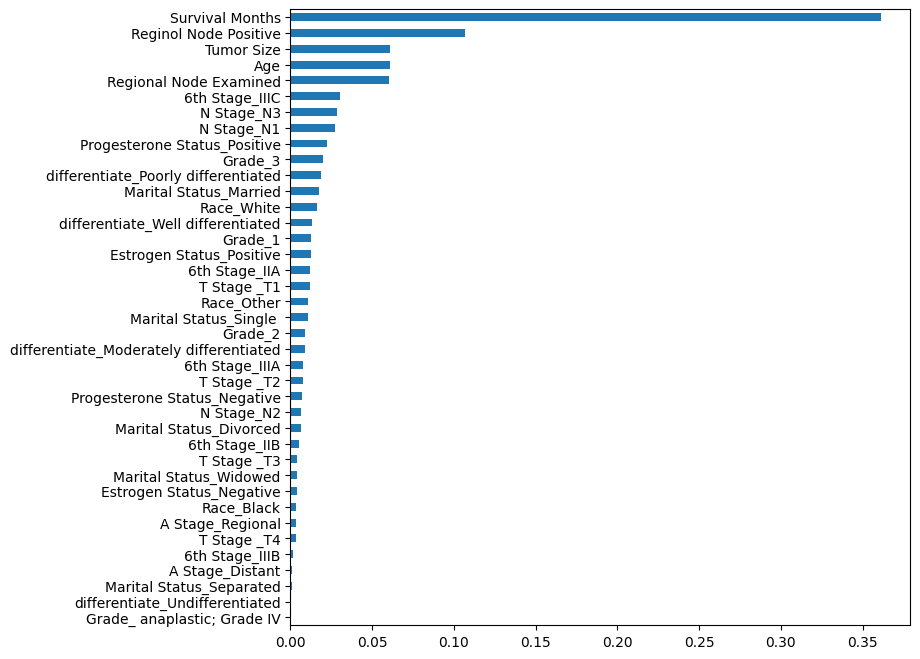

In [ ]:
var_imp = pd.DataFrame({'importance': best_rfmodel.feature_importances_},
                       index=X_train.columns)

var_imp.sort_values(by='importance').plot.barh(figsize=(8,8),
                                               legend=False)

## Gaussian NB

In [ ]:
from sklearn.naive_bayes import GaussianNB


gaussian_nb = GaussianNB()
gaussian_nb = gaussian_nb.fit(X_train[numerical_cols],y_train)
y_pred_gnb = gaussian_nb.predict(X_val[numerical_cols])

results_df.loc['Gaussian-NB', :] = compute_metrics(y_val, y_pred_gnb)
results_df.sort_values(by='**Recall class 1**', ascending=False)

,Accuracy,F1,Precision,Recall,Jaccard
LogReg-0.1,0.773292,0.516556,0.384236,0.787879,0.348214
Gaussian-NB,0.746894,0.485804,0.353211,0.777778,0.320833
KNN-11,0.667702,0.40884,0.281369,0.747475,0.256944
LDA,0.838509,0.566667,0.48227,0.686869,0.395349


## Neural Network

In [ ]:
sizes = [2*i for i in range(1,3)]
sizes = sizes + [[2*i,2*i] for i in range(1,3)]
sizes = sizes + [[2*i,2*i, 2*i] for i in range(1,3)]

print(len(sizes), sizes)


decays = [0.01,0.1,1]
print(len(decays), decays[:10])

6 [2, 4, [2, 2], [4, 4], [2, 2, 2], [4, 4, 4]]
3 [0.01, 0.1, 1]


In [ ]:
from sklearn.neural_network import MLPClassifier


model_nnet = MLPClassifier(hidden_layer_sizes=[2,2,2],
                           alpha=0,
                           activation='logistic',
                           max_iter=1000000,
                           solver='lbfgs',random_state=42)


trc = GridSearchCV(estimator=model_nnet,
                   scoring=['recall', 'f1','accuracy', 'f1_macro', 'precision_macro', 'recall_macro'],
                   param_grid={'hidden_layer_sizes': sizes,
                              'alpha': decays},
                   cv=5,
                   return_train_score=True,
                   refit='recall')


# Fit the GridSearchCV object to the data
trc.fit(X_train, y_train)

# Print the best parameters found by GridSearchCV
print("Best Parameters:", trc.best_params_)

# Print the best score found by GridSearchCV
print("Best Score:", trc.best_score_)

# Get the best model found by GridSearchCV
best_mlpmodel = trc.best_estimator_

c:\Users\nikol\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

c:\Users\nikol\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

c:\Users\nikol\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.



Best Parameters: {'alpha': 0.01, 'hidden_layer_sizes': [4, 4]}
Best Score: 0.9476629105196828


In [ ]:
y_pred_mlp = best_mlpmodel.predict(X_val)
results_df.loc['MLP', :] = compute_metrics(y_val, y_pred_mlp)

results_df.sort_values(by='**Recall class 1**', ascending=False)

,Accuracy,F1,Precision,Recall,Jaccard
KNN-9,0.704969,0.450867,0.315789,0.787879,0.291045
LogReg-0.1,0.763975,0.506494,0.373206,0.787879,0.33913
Random Forest,0.807453,0.530303,0.424242,0.707071,0.360825
LDA,0.835404,0.561983,0.475524,0.686869,0.390805
MLP,0.774845,0.476534,0.370787,0.666667,0.312796


In [ ]:
# Confusion Matrix
confusion(y_val, y_pred_mlp)

predicted,0,1
target,,
0,433,112
1,33,66


## Ensemble

In [ ]:
from sklearn.ensemble import VotingClassifier


voting_best = VotingClassifier([('logreg', logreg),
                                ('knn', knn),
                                ('rf', best_rfmodel)] ,voting='soft')
voting_best.fit(X_train, y_train)

y_pred = voting_best.predict(X_val)

results_df.loc['Ensemble', :] = compute_metrics(y_val, y_pred)

results_df.sort_values(by='**Recall class 1**', ascending=False)

,Accuracy,F1,Precision,Recall,Jaccard
KNN-9,0.704969,0.450867,0.315789,0.787879,0.291045
LogReg-0.1,0.763975,0.506494,0.373206,0.787879,0.33913
Ensemble,0.767081,0.506579,0.37561,0.777778,0.339207
Random Forest,0.807453,0.530303,0.424242,0.707071,0.360825
LDA,0.835404,0.561983,0.475524,0.686869,0.390805
MLP,0.774845,0.476534,0.370787,0.666667,0.312796


## Generalization Performance

In [ ]:
y_pred=logreg.predict(X_test)

In [ ]:
print('accuracy_score: ',accuracy_score(y_test,y_pred))
print('recall_score: ',recall_score(y_test,y_pred))
print('jaccard_score: ',jaccard_score(y_test,y_pred))
print('f1_score: ',f1_score(y_test,y_pred))
print('precision_score: ',precision_score(y_test,y_pred))

fig = px.imshow(np.around(confusion_matrix(y_test, y_pred, normalize='true'),2), 
                template='ggplot2',
                text_auto=True, 
                aspect="True", 
                labels=dict(x="Predicted Label", y="Correct Label", color='Value'))
fig.update_xaxes(side="bottom")
fig.show()

accuracy_score:  0.7552795031055901
recall_score:  0.7398373983739838
jaccard_score:  0.3159722222222222
f1_score:  0.4802110817941953
precision_score:  0.35546875
